# Import library dan download datasets

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import LabelEncoder
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, balanced_accuracy_score 
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score, roc_auc_score,precision_recall_curve

In [ ]:
from google.colab import files
import zipfile

uploaded = files.upload()
with zipfile.ZipFile('openweatherdata-denpasar-1990-2020.zip') as zip_ref:
  zip_ref.extractall()

Saving openweatherdata-denpasar-1990-2020.zip to openweatherdata-denpasar-1990-2020.zip


In [ ]:
df = pd.read_csv('openweatherdata-denpasar-1990-2020v0.1.csv', parse_dates=['dt_iso'])
df.head()

,dt_iso,timezone,city_name,lat,lon,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,rain_6h,rain_12h,rain_24h,rain_today,snow_1h,snow_3h,snow_6h,snow_12h,snow_24h,snow_today,clouds_all,weather_id,weather_main,weather_description,weather_icon
0,1990-01-01 00:00:00,28800,Denpasar,-8.652497,115.219117,25.82,25.82,25.82,1010.0,86,1.36,225,0.49,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,98,500,Rain,light rain,10d
1,1990-01-01 01:00:00,28800,Denpasar,-8.652497,115.219117,26.20,26.20,26.20,1011.0,84,2.09,247,0.13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,91,500,Rain,light rain,10d
2,1990-01-01 02:00:00,28800,Denpasar,-8.652497,115.219117,26.45,26.45,26.45,1011.0,84,2.44,262,0.24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,94,500,Rain,light rain,10d
3,1990-01-01 03:00:00,28800,Denpasar,-8.652497,115.219117,26.80,26.80,26.80,1011.0,82,2.29,271,0.23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,94,500,Rain,light rain,10d
4,1990-01-01 04:00:00,28800,Denpasar,-8.652497,115.219117,27.04,27.04,27.04,1010.0,82,1.71,274,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,76,803,Clouds,broken clouds,04d


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264924 entries, 0 to 264923
Data columns (total 29 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   dt_iso               264924 non-null  datetime64[ns]
 1   timezone             264924 non-null  int64         
 2   city_name            264924 non-null  object        
 3   lat                  264924 non-null  float64       
 4   lon                  264924 non-null  float64       
 5   temp                 264924 non-null  float64       
 6   temp_min             264924 non-null  float64       
 7   temp_max             264924 non-null  float64       
 8   pressure             264924 non-null  float64       
 9   humidity             264924 non-null  int64         
 10  wind_speed           264924 non-null  float64       
 11  wind_deg             264924 non-null  int64         
 12  rain_1h              16286 non-null   float64       
 13  rain_3h       

# Pre-Processing


*   Drop columns yang memiliki nilai null dan tidak dapat digunakan sebagai fitur pada model
*   Drop columns yang memiliki nilai yang sama
*   Drop colum temp_max dan temp_min karena temp, temp_min dan temp_max memiliki similarity 100%




## Persentase null values pada setiap kolom

In [ ]:
percent_null_col = df.isnull().sum() * 100 / len(df)
pm_df = pd.DataFrame({ 'column_name': df.columns,
                       'percent_missing': percent_null_col })
pm_df.sort_values('percent_missing', inplace=True)
drop_col = pm_df.loc[pm_df['percent_missing'] != 0]
drop_col
#plotting percent missing
#ax = pm_df.plot(kind='barh')
#for i, v in enumerate(pm_df.percent_missing):
#    ax.text(v + 3, i + .25, str("%.2f" %v), color='blue', fontweight='bold')

,column_name,percent_missing
rain_6h,rain_6h,86.374205
rain_1h,rain_1h,93.852577
rain_3h,rain_3h,93.901647
rain_24h,rain_24h,97.426809
rain_12h,rain_12h,99.995470
snow_3h,snow_3h,100.000000
snow_6h,snow_6h,100.000000
snow_12h,snow_12h,100.000000
snow_24h,snow_24h,100.000000
snow_today,snow_today,100.000000


In [ ]:
#memiliki nilai null lebih dari 85%
df.drop(df.loc[:, drop_col['column_name']], axis=1, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264924 entries, 0 to 264923
Data columns (total 17 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   dt_iso               264924 non-null  datetime64[ns]
 1   timezone             264924 non-null  int64         
 2   city_name            264924 non-null  object        
 3   lat                  264924 non-null  float64       
 4   lon                  264924 non-null  float64       
 5   temp                 264924 non-null  float64       
 6   temp_min             264924 non-null  float64       
 7   temp_max             264924 non-null  float64       
 8   pressure             264924 non-null  float64       
 9   humidity             264924 non-null  int64         
 10  wind_speed           264924 non-null  float64       
 11  wind_deg             264924 non-null  int64         
 12  clouds_all           264924 non-null  int64         
 13  weather_id    

## identifikasi kolom yang memilki nilai sama pada setiap baris

In [ ]:
# kolom dengan nilai sama untuk seluruh baris
col_identic = df.loc[:,df.apply(lambda col: len(col.unique()) == 1)].columns
col_identic

Index(['timezone', 'city_name', 'lat', 'lon'], dtype='object')

In [ ]:
#nilai yang sama
df.drop(df.loc[:, col_identic], axis=1, inplace=True)

## membandingkan kolom temperatur

In [ ]:
# membandingkan kolomp temperatur
bol = (df['temp'] == df['temp_min']) & \
      (df['temp'] == df['temp_max'])
bol.isnull().sum() #tidak ada nilai kolom yang berbeda pada setiap row

0

In [ ]:
df.drop(['temp_min', 'temp_max'], axis=1, inplace=True) #memilki nilai duplicate 100%
df.drop(['weather_icon','weather_id', 'weather_description'], axis=1, inplace=True) #terwakilkan oleh kolom weather_main

In [ ]:
df.head()

,dt_iso,temp,pressure,humidity,wind_speed,wind_deg,clouds_all,weather_main
0,1990-01-01 00:00:00,25.82,1010.0,86,1.36,225,98,Rain
1,1990-01-01 01:00:00,26.20,1011.0,84,2.09,247,91,Rain
2,1990-01-01 02:00:00,26.45,1011.0,84,2.44,262,94,Rain
3,1990-01-01 03:00:00,26.80,1011.0,82,2.29,271,94,Rain
4,1990-01-01 04:00:00,27.04,1010.0,82,1.71,274,76,Clouds


In [ ]:
df['month'] = df['dt_iso'].dt.month

## Imbalanced Class

In [ ]:
col_del = df.value_counts('weather_main')
col_del = col_del[col_del < 30].index.tolist()

col_del = df.loc[df.weather_main.isin(col_del)]
df.drop(col_del.index, inplace=True)

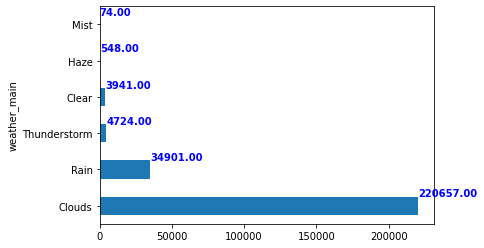

In [ ]:
ax = df.value_counts('weather_main').plot(kind='barh')
for i, v in enumerate(df.value_counts('weather_main')):
    ax.text(v + 10, i + .25, str("%.2f" %v), color='blue', fontweight='bold')

Class=4, n=34901 (13.178%)
Class=1, n=220657 (83.316%)
Class=5, n=4724 (1.784%)
Class=0, n=3941 (1.488%)
Class=2, n=548 (0.207%)
Class=3, n=74 (0.028%)


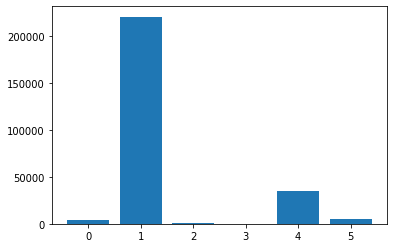

In [ ]:
y = df['weather_main']
X = df.loc[:, ~df.columns.isin(['weather_main', 'dt_iso', 'month'])]
le = LabelEncoder()
y = le.fit_transform(y)
# summarize distribution
counter = Counter(y)
for k,v in counter.items():
	per = v / len(y) * 100
	print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
# plot the distribution
plt.bar(counter.keys(), counter.values())
plt.show()

In [ ]:
from imblearn.over_sampling import ADASYN, SMOTE, RandomOverSampler

# summarize class distribution
counter = Counter(y)
print(counter)
over = ADASYN()

# transform the dataset
X_os, y_os = over.fit_sample(X, y)

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Counter({1: 220657, 4: 34901, 5: 4724, 0: 3941, 2: 548, 3: 74})


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

Class=4, n=222391 (83.970%)
Class=1, n=220657 (83.316%)
Class=5, n=220726 (83.342%)
Class=0, n=220535 (83.269%)
Class=2, n=220555 (83.277%)
Class=3, n=220645 (83.311%)


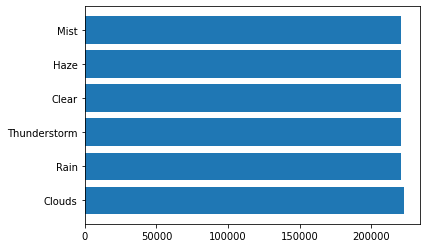

In [ ]:
counter = Counter(y_os)
for k,v in counter.items():
	per = v / len(y) * 100
	print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
# plot the distribution
ax = plt.barh(df.value_counts('weather_main').index, counter.values())
plt.show()

# Prediction

In [ ]:
#before oversampling
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

clf_entropy = DecisionTreeClassifier(max_depth = 15)
nbg = GaussianNB()
# Performing training 
clf_entropy.fit(X_train, y_train)
nbg.fit(X_train, y_train)

print('=====decision tree=====')
y_pred = clf_entropy.predict(X_test)
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test, y_pred, average='weighted')
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test, y_pred, average='weighted')
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, y_pred, average='weighted')
print('F1 score: %f' % f1)
# balanced accuracy = ...
ba = balanced_accuracy_score(y_test, y_pred)
print('Balanced accuracy: %f' %ba)
roc = roc_auc_score(y_test, clf_entropy.predict_proba(X_test), multi_class='ovo')
print('AUC ROC : %f' %roc)

print('=====naive bayes=====')
y_pred = nbg.predict(X_test)
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test, y_pred, average='weighted')
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test, y_pred, average='weighted')
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, y_pred, average='weighted')
print('F1 score: %f' % f1)
# balanced accuracy = ...
ba = balanced_accuracy_score(y_test, y_pred)
print('Balanced accuracy: %f' %ba)
roc = roc_auc_score(y_test, nbg.predict_proba(X_test), multi_class='ovo')
print('AUC ROC : %f' %roc)

=====decision tree=====
Accuracy: 0.870529
Precision: 0.850812
Recall: 0.870529
F1 score: 0.858600
Balanced accuracy: 0.412121


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


AUC ROC : 0.782518
=====naive bayes=====
Accuracy: 0.835162
Precision: 0.827427
Recall: 0.835162
F1 score: 0.824406
Balanced accuracy: 0.254109


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


AUC ROC : 0.822290


In [ ]:
#after oversampling
X_train, X_test, y_train, y_test = train_test_split(X_os, y_os, test_size=0.3)

clf_entropy = DecisionTreeClassifier(max_depth = 15)
nbg = GaussianNB()

# Performing training 
clf_entropy.fit(X_train, y_train)
nbg.fit(X_train, y_train)

print('=====decision tree=====')
y_pred = clf_entropy.predict(X_test)
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test, y_pred, average='weighted')
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test, y_pred, average='weighted')
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, y_pred, average='weighted')
print('F1 score: %f' % f1)
# balanced accuracy = ...
ba = balanced_accuracy_score(y_test, y_pred)
print('Balanced accuracy: %f' %ba)
roc = roc_auc_score(y_test, clf_entropy.predict_proba(X_test), multi_class='ovo')
print('AUC ROC : %f' %roc)

print('=====naive bayes=====')
y_pred = nbg.predict(X_test)
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test, y_pred, average='weighted')
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test, y_pred, average='weighted')
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, y_pred, average='weighted')
print('F1 score: %f' % f1)
# balanced accuracy = ...
ba = balanced_accuracy_score(y_test, y_pred)
print('Balanced accuracy: %f' %ba)
roc = roc_auc_score(y_test, nbg.predict_proba(X_test), multi_class='ovo')
print('AUC ROC : %f' %roc)

=====decision tree=====
Accuracy: 0.826328
Precision: 0.829039
Recall: 0.826328
F1 score: 0.824257
Balanced accuracy: 0.826710
AUC ROC : 0.964273
=====naive bayes=====
Accuracy: 0.569826
Precision: 0.581632
Recall: 0.569826
F1 score: 0.565450
Balanced accuracy: 0.570410
AUC ROC : 0.859661


In [ ]:
#y_norm = df['weather_main']
#X_norm = df.loc[:, ~df.columns.isin(['weather_main', 'dt_iso'])]
#fig = plt.figure(figsize=(25,20))
#_ = plot_tree(clf_entropy, 
#              feature_names=X_norm.columns,  
#              class_names=y_norm,
#              filled=True)


In [ ]:
lst_class = list(np.unique(y))
lst_class

[0, 1, 2, 3, 4, 5]

Average precision score, micro-averaged over all classes: 0.93


Text(0.5, 1.0, 'Average precision score, micro-averaged over all classes: AP=0.93')

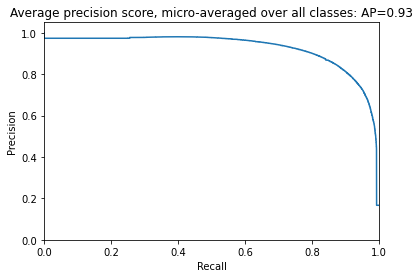

In [ ]:
from sklearn.preprocessing import label_binarize

# Use label_binarize to be multi-label like settings
Y = label_binarize(y_os, classes=lst_class)
n_classes = Y.shape[1]

# Split into training and test
X_train, X_test, Y_train, Y_test = train_test_split(X_os, Y, test_size=.3)

from sklearn.multiclass import OneVsRestClassifier

# Run classifier
classifier = OneVsRestClassifier(clf_entropy)
classifier.fit(X_train, Y_train)
y_pred = classifier.predict_proba(X_test)

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

# For each class
precision = dict()
recall = dict()
average_precision = dict()
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(Y_test[:, i],y_pred[:, i])
    average_precision[i] = average_precision_score(Y_test[:, i], y_pred[:, i])

# A "micro-average": quantifying score on all classes jointly
precision["micro"], recall["micro"], _ = precision_recall_curve(Y_test.ravel(), y_pred.ravel())
average_precision["micro"] = average_precision_score(Y_test, y_pred, average="micro")
print('Average precision score, micro-averaged over all classes: {0:0.2f}'
      .format(average_precision["micro"]))
plt.figure()
plt.step(recall['micro'], precision['micro'], where='post')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title(
    'Average precision score, micro-averaged over all classes: AP={0:0.2f}'
    .format(average_precision["micro"]))

In [ ]:
#using cross validation
print(cross_val_score(clf_entropy, X, y, cv=10))
print(cross_val_score(clf_entropy, X_os, y_os, cv=10))
print(cross_val_score(nbg, X, y, cv=10))
print(cross_val_score(nbg, X_os, y_os, cv=10))